<a href="https://colab.research.google.com/github/juliaOdias/Prever-fechamento-diario/blob/main/FechamentoDiario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas necessárias

In [1]:
!pip install yfinance --quiet
!pip install tensorflow --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 1. Baixar dados da ação

In [2]:
ticker = "AAPL"  # Exemplo: Apple
df = yf.download(ticker, start="2015-01-01", end="2025-12-31")
df = df[['Close']]
df.head()

/tmp/ipython-input-662527365.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2025-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.261047
2015-01-05,23.577576
2015-01-06,23.579790
2015-01-07,23.910435
2015-01-08,24.829130


# 2. Visualizar dados

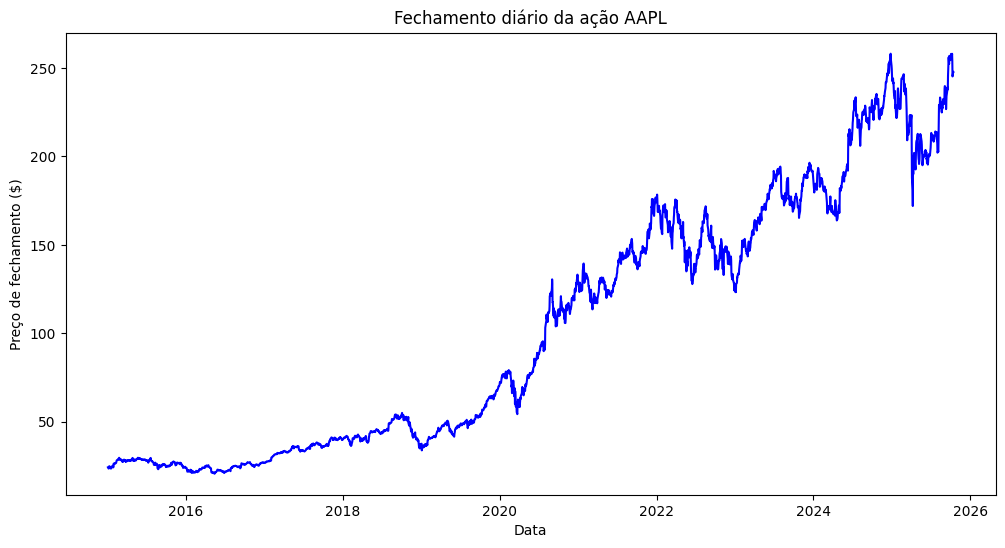

In [3]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], color='blue')
plt.title(f'Fechamento diário da ação {ticker}')
plt.xlabel('Data')
plt.ylabel('Preço de fechamento ($)')
plt.show()

# 3. Pré-processamento

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(df)

# Definir sequência de treino
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape para LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 4. Criar modelo LSTM

In [5]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Treinar modelo

In [6]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0230 - val_loss: 0.0014
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 3.3072e-04 - val_loss: 0.0016
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 3.0514e-04 - val_loss: 0.0019
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 3.1175e-04 - val_loss: 0.0014
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 2.8715e-04 - val_loss: 0.0012
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 2.5418e-04 - val_loss: 0.0019
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 2.4732e-04 - val_loss: 0.0024
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 2.1901e-04 - val_loss: 0.0018
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 2.3526e-04 - val_loss: 0.0013
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 2.1994e-04 - val_loss: 0.0016
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 2.2832e-04 - val_loss: 0.0011
Epoch 12/20
66/66 ━━━━━

# 6. Fazer previsões

In [7]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


# 7. Visualização

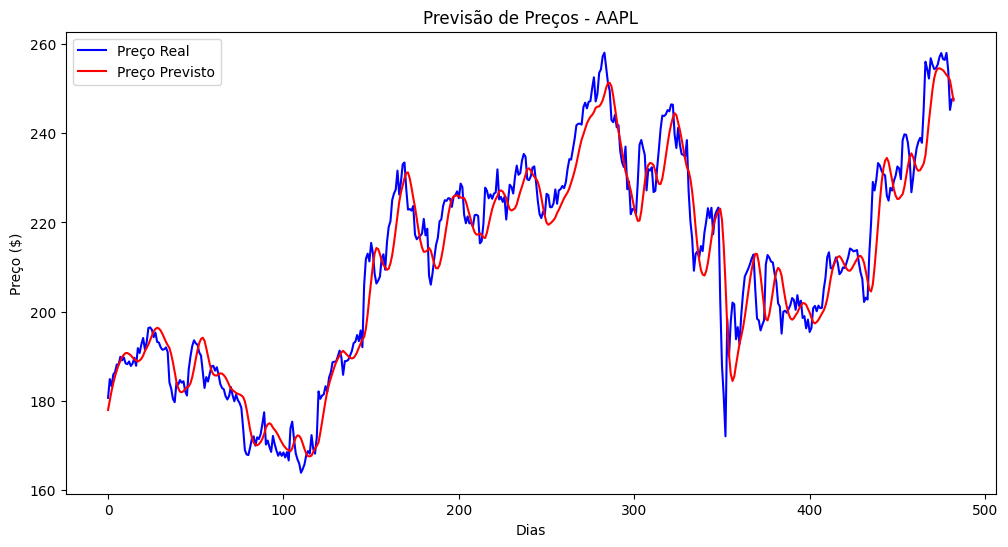

In [8]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, color='blue', label='Preço Real')
plt.plot(y_pred_rescaled, color='red', label='Preço Previsto')
plt.title(f'Previsão de Preços - {ticker}')
plt.xlabel('Dias')
plt.ylabel('Preço ($)')
plt.legend()
plt.show()

# 8. Métricas

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error (MSE): 42.59
R² Score: 0.92
